In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Data is obtained from UCI's Machine Learning Repository.  It is from a UK online retailer that sells gift item to several customers across Europe.

Link : https://archive.ics.uci.edu/ml/datasets/Online+Retail

In [2]:
data = pd.read_csv(r'C:\Users\shaba\Online Retail.csv')

In [3]:
# See the columns
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [4]:
# See the first 5 rows of data
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
# Add a revenue columns, multiplying quanity and unit price
data["Revenue"] = data['Quantity'] * data['UnitPrice']

In [6]:
# See head with revenue added
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [7]:
# Data type information on columns.  Date is an object, will need to be modified at least for time series
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
Revenue        541909 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


To begin the exploration let's look at the data at a transaction level.  First the data will need to be grouped, and we will add an ASP column as well.

In [8]:
# Group data by transactions with Revenue and Quantity columns
trans_grouped = data.groupby(by='InvoiceNo')['Quantity','Revenue'].sum()

In [9]:
# Add ASP to grouped transactions and 
trans_grouped['ASP'] = trans_grouped['Revenue'] / trans_grouped['Quantity']
trans_grouped.head()

,Quantity,Revenue,ASP
InvoiceNo,,,
536365,40,139.12,3.478000
536366,12,22.20,1.850000
536367,83,278.73,3.358193
536368,15,70.05,4.670000
536369,3,17.85,5.950000


Now that the data is gropued, let's look at some basic information.  There are 25,900 transactions, 5,176,405 units sold, and revenue of $9,747,747 in revenue.

In [10]:
# Look at number of transactions
trans_count = len(trans_grouped)
print('# of Transactions: {}'.format(trans_count))
print('Total Revenue: {}'.format(sum(trans_grouped['Revenue'])))
print('Total Units: {}'.format(sum(trans_grouped['Quantity'])))

# of Transactions: 25900
Total Revenue: 9747747.934000194
Total Units: 5176450


In [11]:
trans_grouped.describe()

,Quantity,Revenue,ASP
count,25900.000000,25900.000000,25900.000000
mean,199.862934,376.360924,20.924427
std,1108.563551,2013.261050,433.309380
min,-80995.000000,-168469.600000,-11062.060000
25%,6.000000,11.775000,1.285517
50%,100.000000,207.535000,1.933474
75%,240.000000,409.085000,3.020631
max,80995.000000,168469.600000,38970.000000


Looking at the descriptive statistics it looks like the average transaction has 200 units, revenue of 376 and and ASP of 20.92. 
Based on the negative minimum quantity and revenue it appears there are returns.  Since out primary concern is sales, returns can be excluded at least at this initial exploration point.  It appears there are returns in the dataset.  Our primary concern is sales, so negative unit products will be excluded.

In [12]:
# Exclude returns and some outlier large transactions.  The 75% percentile is 240 units, let's also cut it off there.
sales_data = data.loc[(data["Quantity"]>0) & (data["Quantity"]<241)]

In [13]:
sales_data.describe()

,Quantity,UnitPrice,CustomerID,Revenue
count,529909.000000,529909.000000,396620.000000,529909.000000
mean,8.970378,3.863849,15293.158134,17.965652
std,17.954698,41.864030,1712.482367,78.180387
min,1.000000,-11062.060000,12347.000000,-11062.060000
25%,1.000000,1.250000,13969.000000,3.750000
50%,3.000000,2.080000,15157.000000,9.900000
75%,10.000000,4.130000,16794.000000,17.500000
max,240.000000,13541.330000,18287.000000,38970.000000


It looks like there is still negative revenue transactions at this point, we can revisit that later to determine if it that is valid.

In [14]:
#Regroup sales transactions
sales_trans_grouped = sales_data.groupby('InvoiceNo')['Quantity','Revenue'].sum()
sales_trans_grouped['ASP'] = sales_trans_grouped["Revenue"]/ sales_trans_grouped['Quantity']

In [15]:
# Look at number of transactions
print('Number of transactions: {}'.format(len(sales_trans_grouped)))
print('Total Revenue: {}'.format(sum(sales_trans_grouped['Revenue'])))
print('Total Units: {}'.format(sum(sales_trans_grouped['Quantity'])))

Number of transactions: 20496
Total Revenue: 9520160.614000008
Total Units: 4753484


When we focus on sales transactions only that reduces our transaction count from 25,900 to 20,496.  Still a good number of transactions for analysis.  Next let's look at the descriptive statistics for this reduced group.>

In [16]:
sales_trans_grouped.describe()

,Quantity,Revenue,ASP
count,20496.000000,20496.000000,20496.000000
mean,231.922521,464.488711,6.211426
std,398.969150,943.017712,190.842188
min,1.000000,-11062.060000,-11062.060000
25%,62.000000,136.600000,1.389987
50%,142.500000,293.780000,1.923549
75%,274.000000,472.367500,2.784477
max,13097.000000,38970.000000,13541.330000


For sales transactions it looks like the average revenue is 465, with 232 units and ASP of 6.21.  Based on that ASP it looks like most of the items they sell are of a lower dollar value.  The 75% percentile for ASP reinforces that as it's only 2.78.  But based on the max of 13,541 it looks like there are some transactions with individual products that are very highly priced. We'll have ot look for more detail on those higher priced items later and see if they are valid o be included. Next lets look at histograms to see distribution for ASP, Quantity and Revenue.

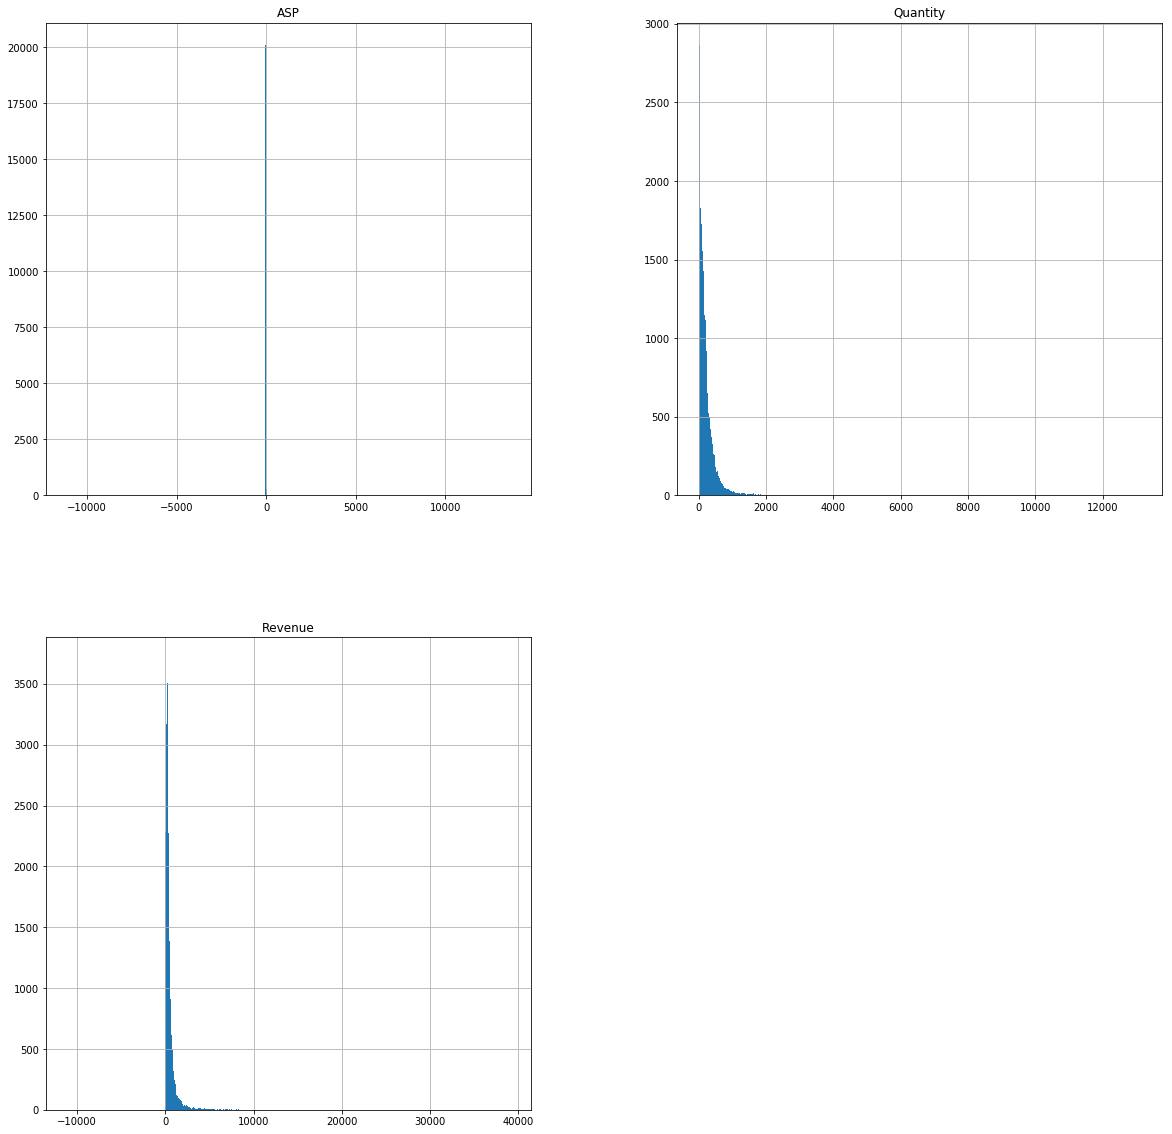

In [17]:
sales_trans_grouped.hist(bins=500, figsize=(20,20))
plt.show()

The histograms reinforce what we saw with the descriptive statistics, most transactions are at the lower end of Revenue, ASP and Quantity.  Let's look at boxplots for a different view of the distributions of Quantity and Revenue.

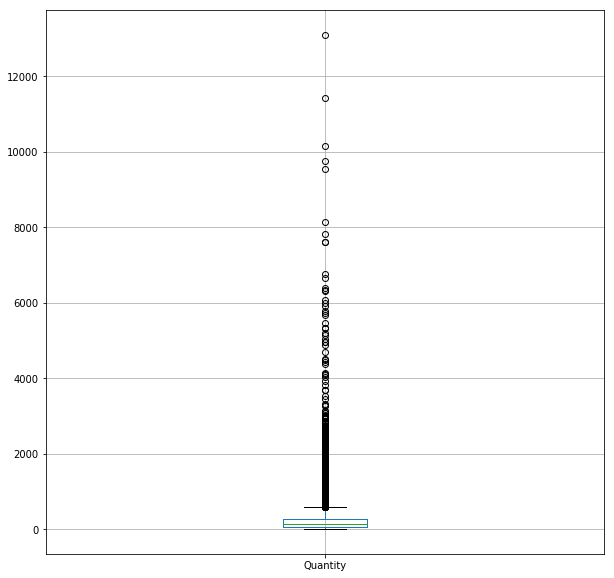

In [18]:
sales_trans_grouped.boxplot(column='Quantity', figsize=(10,10))
plt.show()

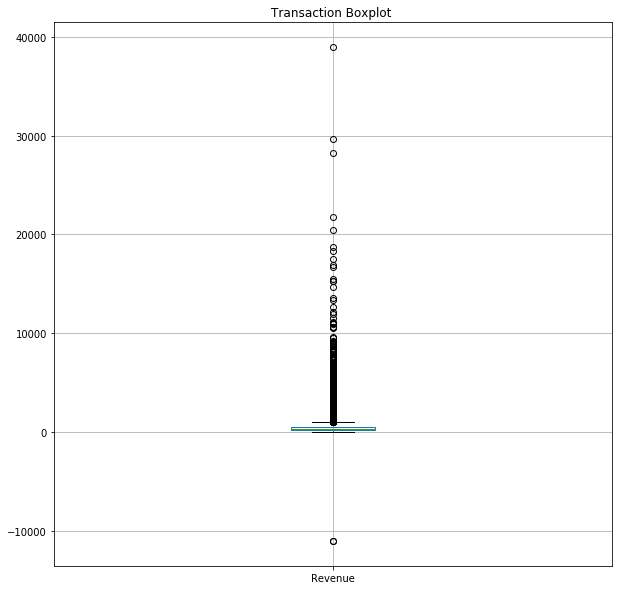

In [19]:
sales_trans_grouped.boxplot(column='Revenue', figsize=(10,10))
plt.title('Transaction Boxplot ')
plt.show()

The box plots alighn with everything we've seen in regards to individual transactions.  Now that we have a general idea about those, let's look at the data form a customer perspective.

In [20]:
#Regroup data at the customer level
sales_cust_grouped = sales_data.groupby('CustomerID')['Quantity','Revenue'].sum()
sales_cust_grouped['ASP'] = sales_cust_grouped["Revenue"]/ sales_cust_grouped['Quantity']

In [21]:
# Descriptive statistics for the customer level data
sales_cust_grouped.describe()

,Quantity,Revenue,ASP
count,4318.000000,4318.000000,4318.000000
mean,1001.908059,1814.947847,3.244229
std,3688.472792,6501.983513,35.717826
min,1.000000,2.900000,0.251732
25%,157.000000,304.305000,1.429828
50%,367.000000,663.630000,1.825013
75%,939.750000,1624.840000,2.381684
max,156113.000000,234407.440000,2033.100000


First, we can see there are 4,318 customers. There are interesting gaps in the customers looking at the revenue alone.  The average customer has spent 1,1815, the smallest 2.90 and the biggest over 234,407.  It appears they have some large customers, but also service small customers as well.  The gaps in quantity are also similar, with the biggest customers purchasing over 156,113 units, versus a mean of 1,001 and 75th percentile of 939. Let's look at boxplots for ASP, Quanity and Revenue at the customer level.

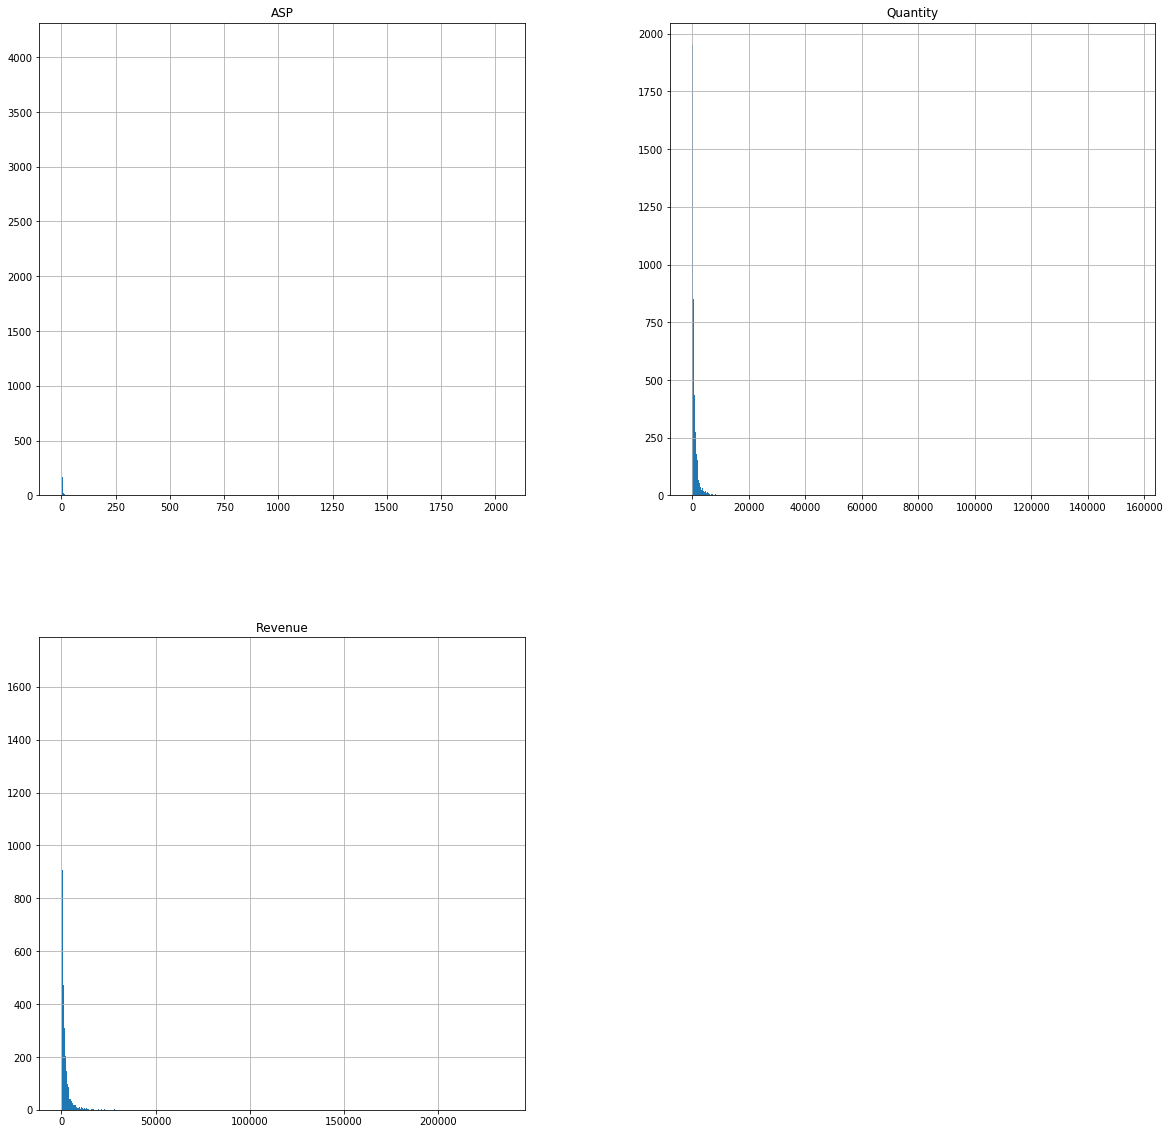

In [22]:
sales_cust_grouped.hist(bins=500, figsize=(20,20))
plt.show()

Due to the large gaps we identified from the descriptive statistics it is difficult to get much meaningful information from the histograms, other than that there are large gaps. Let's look at boxplot which should just confirm this, but may give a better idea of exactly what the outliers look like

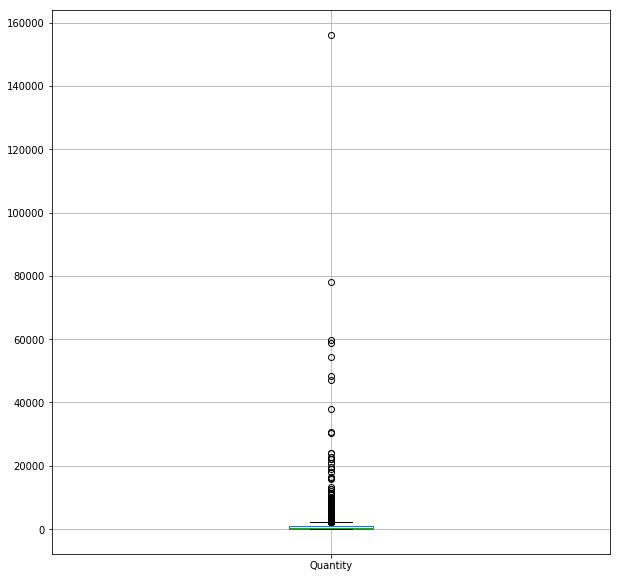

In [23]:
sales_cust_grouped.boxplot(column='Quantity', figsize=(10,10))
plt.show()

We see there is a very large unit customers at 175,000 with the next customer at less than half that amount just above 75,000.  Let's look at how this is shown when we look at revenue.

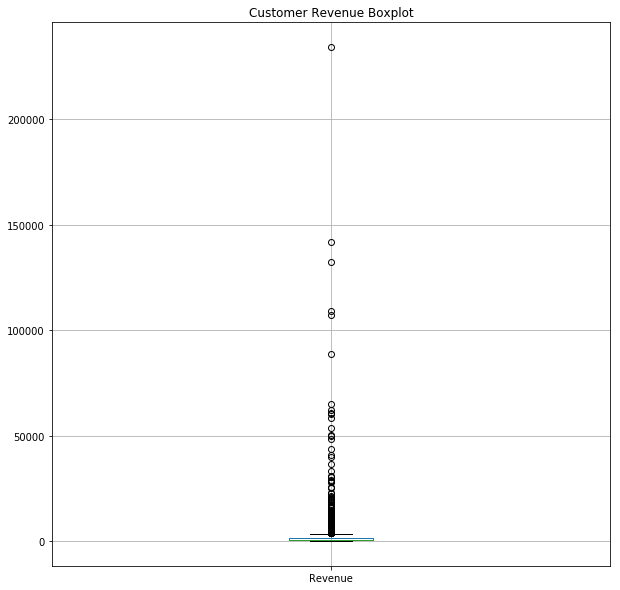

In [24]:
sales_cust_grouped.boxplot(column='Revenue', figsize=(10,10))
plt.title('Customer Revenue Boxplot')
plt.show()

Again, we see the very large customer with close to 250,000 in revenue.  It is interesting to note there are quite a few customers between 50,000 to 150,000.  And a bigger cluster in the lower thousands up to 50,000. Lets try to remove some of the larger customers by limiting units to the 75th percentile.  This should help us have a better understanding of the majority of the customers.

In [25]:
# Limit sales customer grouping to 940 units, 939 units is the 75th percentile.
sales_cust_grouped_75 = sales_cust_grouped.loc[sales_cust_grouped['Quantity'] < 939]

In [26]:
sales_cust_grouped_75.describe()

,Quantity,Revenue,ASP
count,3237.000000,3237.000000,3237.000000
mean,313.106271,610.996084,3.749887
std,238.452205,862.401832,41.240606
min,1.000000,2.900000,0.251732
25%,123.000000,231.860000,1.464228
50%,246.000000,439.030000,1.906064
75%,463.000000,814.000000,2.542194
max,938.000000,39916.500000,2033.100000


When we exclude some of the bigger customers we are still left from 3,237 customers, from our previous total of 4,318.  Interestingly this caps are biggest customer at 39,917 in revenue.  The average units ordered are 313 and 610 in revenue.  Let's look at histograms for distributions of these customers.

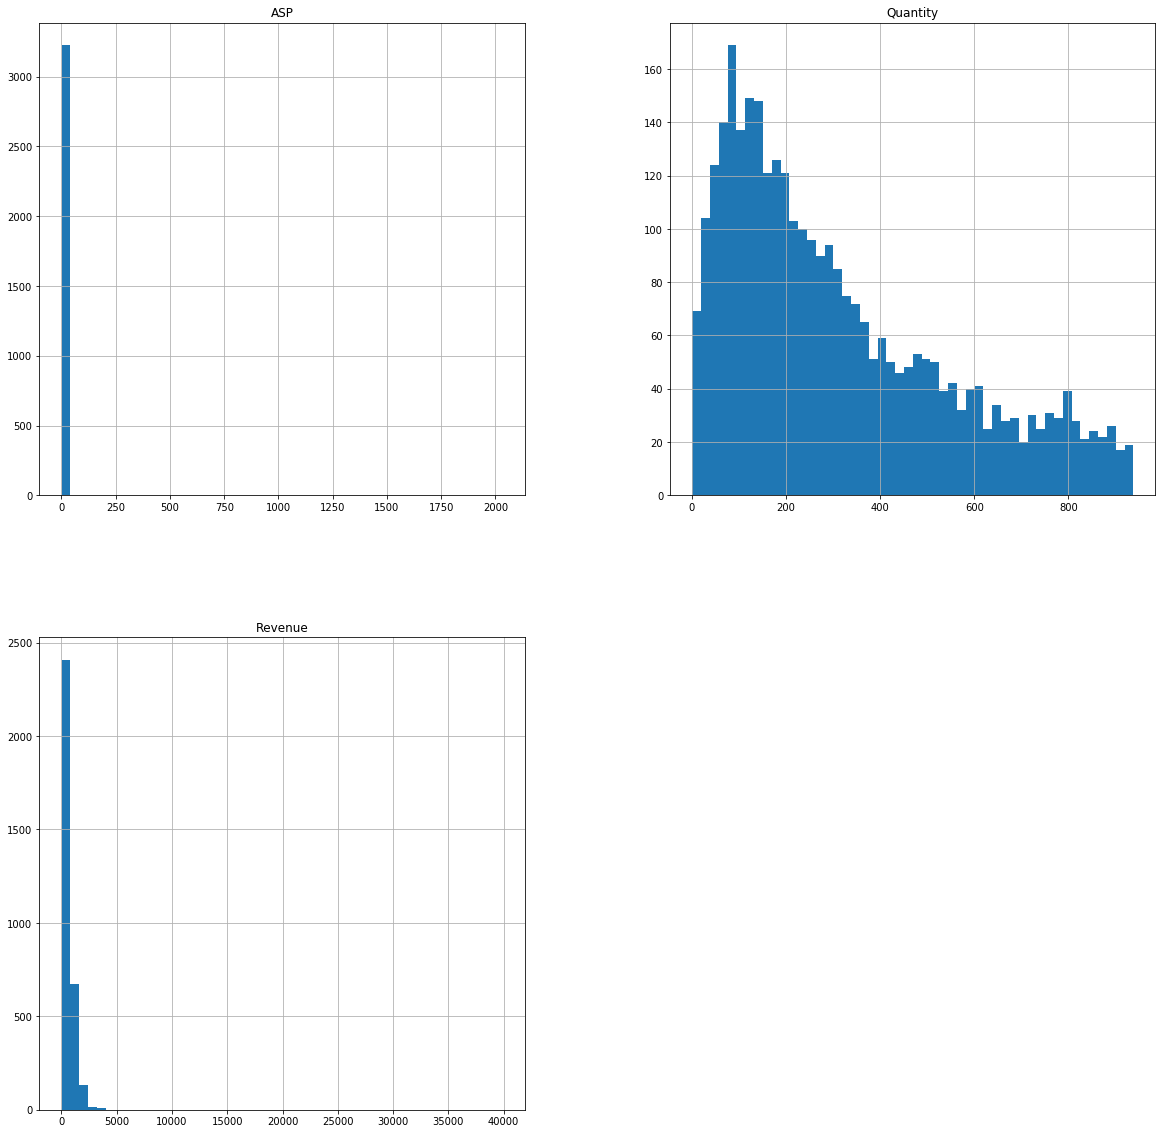

In [27]:
sales_cust_grouped_75.hist(bins=50, figsize=(20,20))
plt.show()

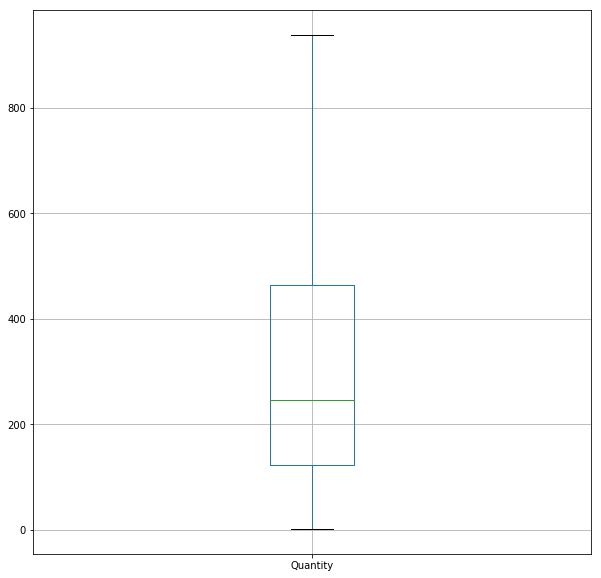

In [28]:
sales_cust_grouped_75.boxplot(column='Quantity', figsize=(10,10))
plt.show()

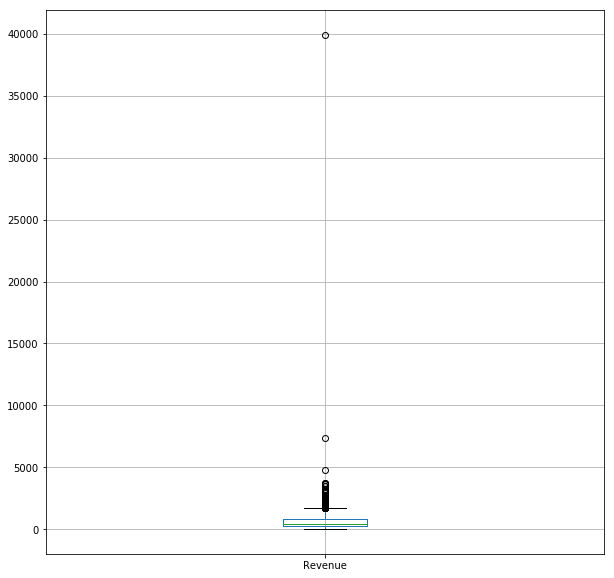

In [29]:
sales_cust_grouped_75.boxplot(column='Revenue', figsize=(10,10))
plt.show()

In [30]:
sales_trans_grouped_75 = sales_trans_grouped.loc[sales_trans_grouped['Quantity'] < 289]

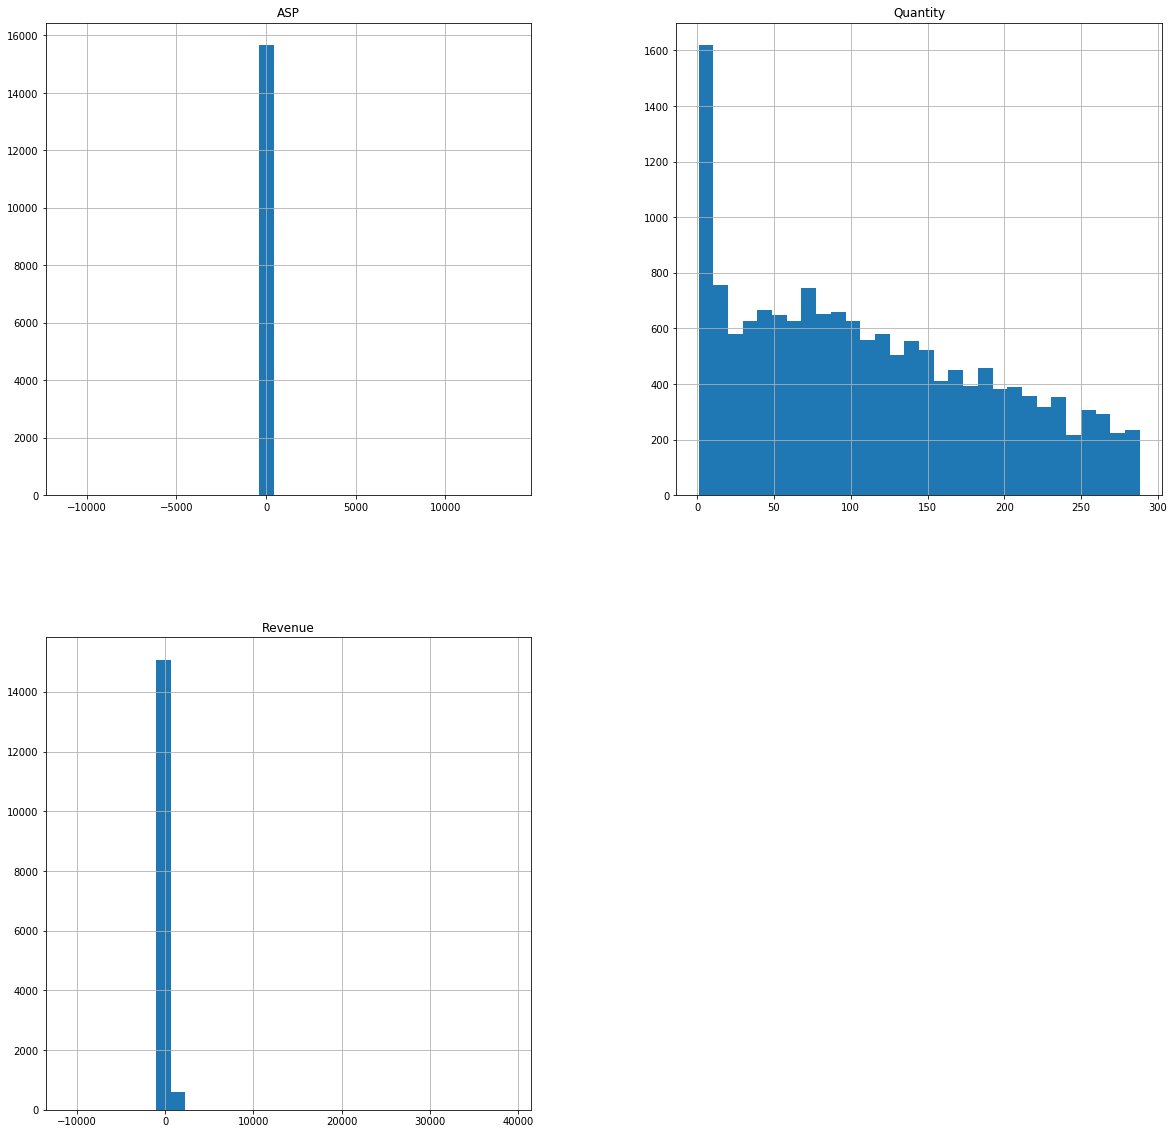

In [31]:
sales_trans_grouped_75.hist(bins=30, figsize=(20,20))
plt.show()

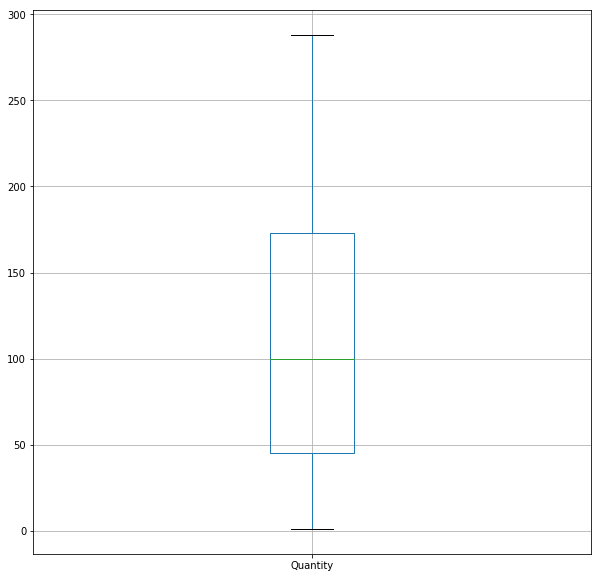

In [32]:
sales_trans_grouped_75.boxplot(column='Quantity', figsize=(10,10))
plt.show()

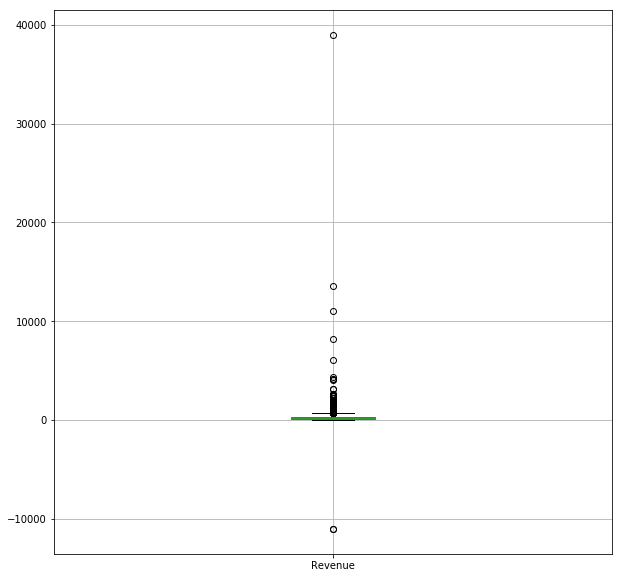

In [33]:
sales_trans_grouped_75.boxplot(column='Revenue', figsize=(10,10))
plt.show()

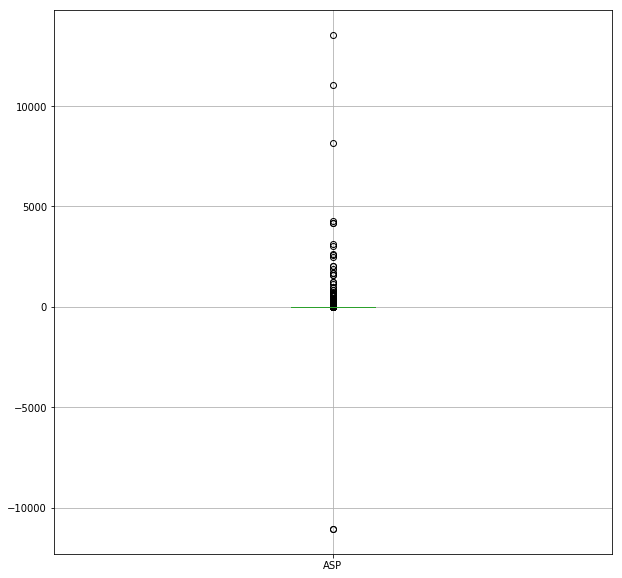

In [34]:
sales_trans_grouped_75.boxplot(column='ASP', figsize=(10,10))
plt.show()